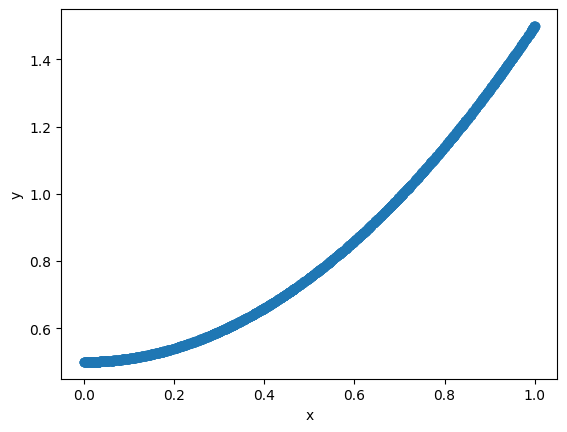

In [37]:
import torch

torch.manual_seed(0)

batch_size = 16

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.00):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((batch_size, num_points))
    # data_x = data_x[3].repeat((batch_size, 1))
    noise = torch.randn((batch_size, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

data_x, data_y = generate_data()

# Plot the data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(data_x, data_y);
ax.set_xlabel('x');
ax.set_ylabel('y');

In [38]:
import theseus as th

# data is of type Variable
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# optimization variables are of type Vector with 1 degree of freedom (dof)
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

In [39]:
def quad_error_fn(optim_vars, aux_vars):
    a, b = optim_vars 
    x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

optim_vars = a, b
aux_vars = x, y
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)
optimizer = th.DCem(
    objective,
    max_iterations = 50,
    n_sample = 100,
    n_elite= 5,
    temp = 1.0
)
theseus_optim = th.TheseusLayer(optimizer)


Best solution: tensor([[ 1.0002e+00,  4.9993e-01,  1.8392e-05],
        [ 1.0001e+00,  4.9996e-01,  1.3278e-05],
        [ 1.0065e+00,  4.9739e-01,  6.0597e-04],
        [ 1.0188e+00,  4.9105e-01,  1.5614e-03],
        [ 1.0008e+00,  4.9964e-01,  1.0465e-04],
        [ 1.0010e+00,  4.9957e-01,  9.3116e-05],
        [ 1.0049e+00,  4.9807e-01,  2.4877e-04],
        [ 1.0056e+00,  4.9718e-01,  9.8361e-04],
        [ 1.0067e+00,  4.9669e-01,  9.4351e-04],
        [ 1.0570e+00,  4.7504e-01,  5.1551e-03],
        [ 1.0009e+00,  4.9957e-01,  1.5086e-04],
        [ 1.0008e+00,  4.9973e-01,  7.1316e-05],
        [ 1.0089e+00,  4.9577e-01,  9.9299e-04],
        [ 1.0010e+00,  4.9950e-01,  1.3132e-04],
        [ 1.0002e+00,  4.9994e-01, -3.3885e-06],
        [ 1.0001e+00,  4.9997e-01,  6.3860e-06]])
tensor(1.0071) tensor(0.4968)


RuntimeError: The size of tensor a (16) must match the size of tensor b (100) at non-singleton dimension 0

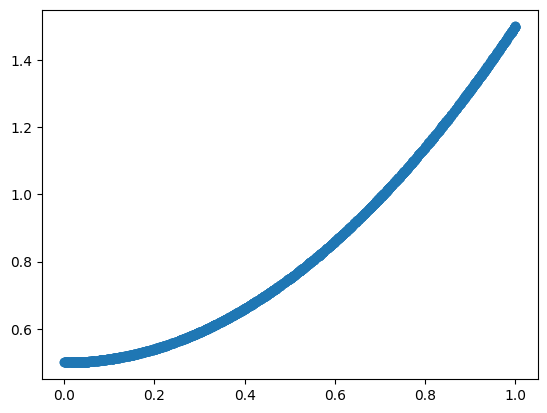

In [40]:
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 2 * torch.ones((batch_size, 1)),
"b": torch.ones((batch_size, 1))*0.5
}
with torch.no_grad():
    updated_inputs, info = theseus_optim.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "track_err_history": True, "verbose":False})
print("Best solution:", torch.cat([a.tensor, b.tensor, quad_error_fn([a,b], [x,y]).mean(dim=1, keepdim=True)], dim=1))
print(a.tensor.mean(),b.tensor.mean())
# Plot the optimized function
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);

a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x = torch.linspace(0., 1., steps=100)
y = a*x*x + b
ax.plot(x, y, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');